## **Plant height measure**

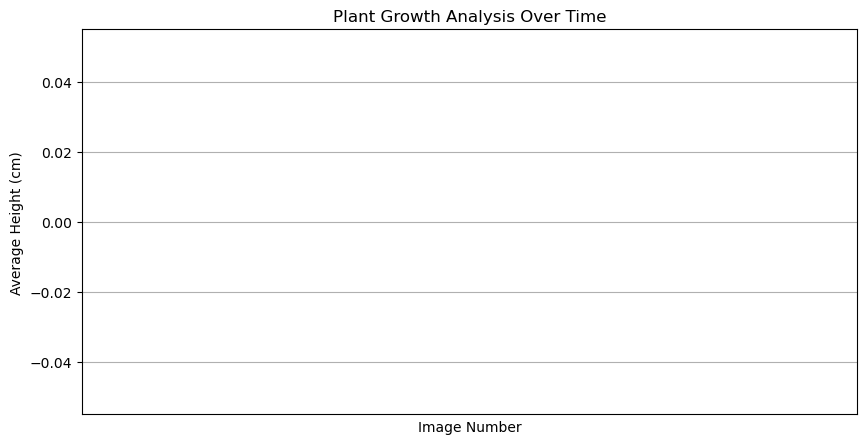

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def preprocess_image(image_path):
    image = cv2.imread(str(image_path))
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    blurred_image = cv2.GaussianBlur(hsv_image, (5, 5), 0)
    return blurred_image, image

def segment_plant(blurred_image):
    lower_green = np.array([30, 40, 40])  # Adjust these values as needed
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(blurred_image, lower_green, upper_green)

    # Apply morphological opening to remove small noise
    kernel = np.ones((5, 5), np.uint8)  # Define a kernel for morphological operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Apply opening
    return mask

def extract_features(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:  # Filter small contours
            bounding_box = cv2.boundingRect(contour)
            height = bounding_box[3]  # Height of the bounding box in pixels
            features.append((area, height, bounding_box))
    return features

def measure_height_in_cm(pixel_height, reference_height_cm, image_height_pixels):
    return (pixel_height / image_height_pixels) * reference_height_cm

def visualize_growth(image, mask, features, reference_height_cm, image_height_pixels):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    
    # Display original image
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    
    # Draw bounding boxes on original image
    for area, height, bounding_box in features:
        x, y, w, h = bounding_box
        # Add rectangle to the plot
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Calculate and display height measurement
        plant_height_cm = measure_height_in_cm(height, reference_height_cm, image_height_pixels)
        plt.text(x, y-10, f'Height: {plant_height_cm:.2f} cm', color='blue', fontsize=9, 
                 bbox=dict(facecolor='white', alpha=0.7))
    
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Segmented Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    return [measure_height_in_cm(height, reference_height_cm, image_height_pixels) for _, height, _ in features]

# Example usage for multiple images
image_paths = []
input_path = Path('images/height')
for image_file in input_path.rglob('*.jpg'):
        image_paths.append(image_file)

reference_height_cm = 25  # Height of the reference object in cm
growth_data = []

for image_path in image_paths:
    blurred_image, original_image = preprocess_image(image_path)
    mask = segment_plant(blurred_image)
    features = extract_features(mask)

    # Use the height of the original image as the reference height in pixels
    image_height_pixels = original_image.shape[0]
    
    heights = visualize_growth(original_image, mask, features, reference_height_cm, image_height_pixels)
    growth_data.append(np.mean(heights) if heights else 0)  # Store average height for the image

# Plotting the growth analysis graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(growth_data) + 1), growth_data, marker='o')
plt.title('Plant Growth Analysis Over Time')
plt.xlabel('Image Number')
plt.ylabel('Average Height (cm)')
plt.xticks(range(1, len(growth_data) + 1))
plt.grid()
plt.show()